# Example A/B test analysis (performed on filler data)

## Setup

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import sem
import seaborn as sns

### Settings

In [2]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)

### Global variables

In [3]:
FILENAME = 'filler_facebook_ad_data.csv'
DECIMAL_PLACES = 5
REGEXPS = {
    'Creative': r'(Set[A-Z])',
    'Message': r'(M[0-9]+)'
}
COLUMN_AGG = {
    'Impressions': sum,
    'Reach': sum,
    'Clicks (all)': sum,
    'Unique clicks (all)': sum
}
COLUMN_NAMES = {
    'Impressions': 'Impressions',
    'Reach': 'Unique Impressions',
    'Clicks (all)': 'Clicks',
    'Unique clicks (all)': 'Unique Clicks'
}
METRICS = {}
for item in ['Clicks', 'Impressions']:
    METRICS[item] = [f'{adjective}{item}' for adjective in ['', 'Unique ']]

### Create dataframe

In [4]:
df = pd.read_csv(FILENAME)

In [5]:
df.drop(
    columns=[
        'Reporting starts',
        'Reporting ends',
    ],
    axis=1,
    inplace=True
)

In [6]:
for type in REGEXPS:
    df[type] = df['Ad Set Name'].str.extract(REGEXPS[type])

In [7]:
display(df.head())

,Ad Set Name,Campaign Name,Impressions,Reach,Clicks (all),Unique clicks (all),Creative,Message
0,SetA M1,filler_data,1163,918,117,91,SetA,M1
1,SetA M2,filler_data,1120,996,7,5,SetA,M2
2,SetA M3,filler_data,1185,959,394,342,SetA,M3
3,SetA M4,filler_data,1152,1036,120,106,SetA,M4
4,SetA M5,filler_data,1190,975,139,112,SetA,M5


## Define functions

In [8]:
def rounded_display(df: pd.DataFrame) -> None:
    df_rounded = df.round(decimals=DECIMAL_PLACES)
    display(df_rounded)

In [9]:
def get_agg_data(df: pd.DataFrame, aggregation: str) -> pd.DataFrame:
    agg_df = df.groupby(aggregation).agg(COLUMN_AGG).reset_index().rename(columns=COLUMN_NAMES)
    for item in ['', 'Unique ']:
            agg_df[f'{item}Clicks per {item}Impression'] = agg_df[f'{item}Clicks']/agg_df[f'{item}Impressions']
    return agg_df

In [10]:
def get_dist(df: pd.DataFrame, aggregation: str, set: str, impression_metric: str, click_metric: str) -> np.array:
    N = df[df[aggregation] == set][impression_metric].sum()
    K = df[df[aggregation] == set][click_metric].sum()
    return np.array([0] * (N-K) + [1] * K)

In [11]:
def get_metric_with_stder(df: pd.DataFrame, aggregation: str, unique: bool) -> pd.DataFrame:
    agg_df = get_agg_data(df=df, aggregation=aggregation)
    adjective = 'Unique ' * unique
    cols = [aggregation, f'{adjective}Clicks per {adjective}Impression', 'Standard Error']
    agg_df.sort_values(by=cols[1], ascending=False, inplace=True)
    stders = []
    for set in agg_df[aggregation]:
            stder = sem(
                get_dist(
                    df=agg_df,
                    aggregation=aggregation,
                    set=set,
                    impression_metric=f'{adjective}Impressions',
                    click_metric=f'{adjective}Clicks'
                )
            )
            stders.append(stder)
    agg_df['Standard Error'] = stders
    return agg_df.loc[:, cols]

In [12]:
def display_metric_bar(df: pd.DataFrame, aggregation: str, metric: str) -> None:
    std = np.std(df[metric])
    mean = np.mean(df[metric])
    median = np.median(df[metric])
    sns.set(rc={'figure.figsize':(16,8)})
    _, ax = plt.subplots(figsize=(16, 8))
    ax.bar(df[aggregation], df[metric])
    ax.axhline(y=mean, color="g", label=f"mean: {mean}")
    ax.axhline(y=median, color="r", label=f"median: {median}")
    plt.legend()
    plt.grid(axis="x", alpha=0.75)
    plt.xticks(rotation=45)
    plt.figtext(1, 0, f'std: {std}', ha='right')
    plt.title(f'{metric}')

In [13]:
def display_scatter_with_stder(df: pd.DataFrame, aggregation: str, metric: str) -> None:
    sns.set(rc={'figure.figsize':(16,8)})
    _, ax = plt.subplots(figsize=(16, 8))
    ax.scatter(df[aggregation], df[metric])
    ax.errorbar(df[aggregation], df[metric], yerr=df['Standard Error'], fmt='o')
    plt.grid(axis="x", alpha=0.75)
    plt.xticks(rotation=45)
    plt.title(f'{metric} (Error Bars)')

In [14]:
def get_pval(df, aggregation: str, larger_val_set: str, smaller_val_set: str, impression_metric, click_metric):
    compare_list = [larger_val_set, smaller_val_set]
    arr = {}
    for set in compare_list:
        arr[set] = get_dist(
            df=df,
            aggregation=aggregation,
            set=set,
            impression_metric=impression_metric,
            click_metric=click_metric
        )
    _, pval = ttest_ind(arr[larger_val_set], arr[smaller_val_set], alternative='greater')
    return pval

In [15]:
def get_pval_table(df, aggregation: str, impression_metric: str, click_metric: str) -> None:
    test_frame = pd.DataFrame()
    agg_df = get_agg_data(df=df, aggregation=aggregation)
    agg_df.sort_values(by=click_metric, ascending=True, inplace=True)
    test_frame[aggregation] = agg_df[aggregation]
    for set in agg_df[aggregation]:
        test_frame[set] = test_frame.apply(
            lambda x: get_pval(
                df=agg_df,
                aggregation=aggregation,
                larger_val_set=x[aggregation],
                smaller_val_set=set,
                impression_metric=impression_metric,
                click_metric=click_metric
            ),
            axis=1
        )
    test_frame.set_index(aggregation, inplace=True)
    sns.set(rc={'figure.figsize':(16,8)})
    plt.figure()
    sns.heatmap(test_frame, annot=True)
    plt.title(f'p-values from one-tailed t-test (row set CTR > column set CTR, [{click_metric}]/[{impression_metric}]):')

In [16]:
def get_pivot_table(df: pd.DataFrame, feature: str) -> None:
    print(f'{feature}:')
    rounded_display(
        pd.pivot_table(
            data=df,
            index=['Creative'],
            columns=['Message'],
            values=feature,
            aggfunc=sum
        )
    )

## Display data

### Aggregated by individual ad

In [17]:
rounded_display(df=get_agg_data(df=df, aggregation='Ad Set Name'))

,Ad Set Name,Impressions,Unique Impressions,Clicks,Unique Clicks,Clicks per Impression,Unique Clicks per Unique Impression
0,SetA M1,1163,918,117,91,0.10060,0.09913
1,SetA M2,1120,996,7,5,0.00625,0.00502
2,SetA M3,1185,959,394,342,0.33249,0.35662
3,SetA M4,1152,1036,120,106,0.10417,0.10232
4,SetA M5,1190,975,139,112,0.11681,0.11487
5,SetA M6,1150,897,80,64,0.06957,0.07135
6,SetA M7,1166,886,450,382,0.38593,0.43115
7,SetA M8,1140,923,31,24,0.02719,0.02600
8,SetB M1,1139,877,249,214,0.21861,0.24401
9,SetB M2,1109,865,127,114,0.11452,0.13179


,Ad Set Name,Clicks per Impression,Standard Error
15,SetB M8,0.38814,0.01461
6,SetA M7,0.38593,0.01426
11,SetB M4,0.34083,0.01422
2,SetA M3,0.33249,0.01369
12,SetB M5,0.25419,0.01262
8,SetB M1,0.21861,0.01225
10,SetB M3,0.19623,0.01163
4,SetA M5,0.11681,0.00931
9,SetB M2,0.11452,0.00957
3,SetA M4,0.10417,0.00900


,Ad Set Name,Unique Clicks per Unique Impression,Standard Error
6,SetA M7,0.43115,0.01665
11,SetB M4,0.40355,0.01689
15,SetB M8,0.38788,0.01549
2,SetA M3,0.35662,0.01548
8,SetB M1,0.24401,0.01451
12,SetB M5,0.22732,0.01310
10,SetB M3,0.21799,0.01344
9,SetB M2,0.13179,0.01151
4,SetA M5,0.11487,0.01022
3,SetA M4,0.10232,0.00942


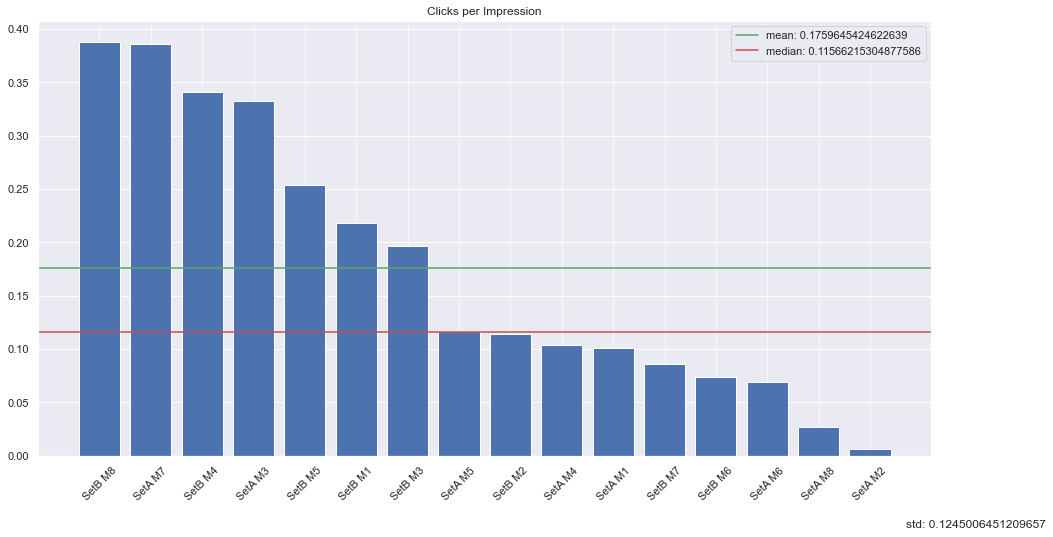

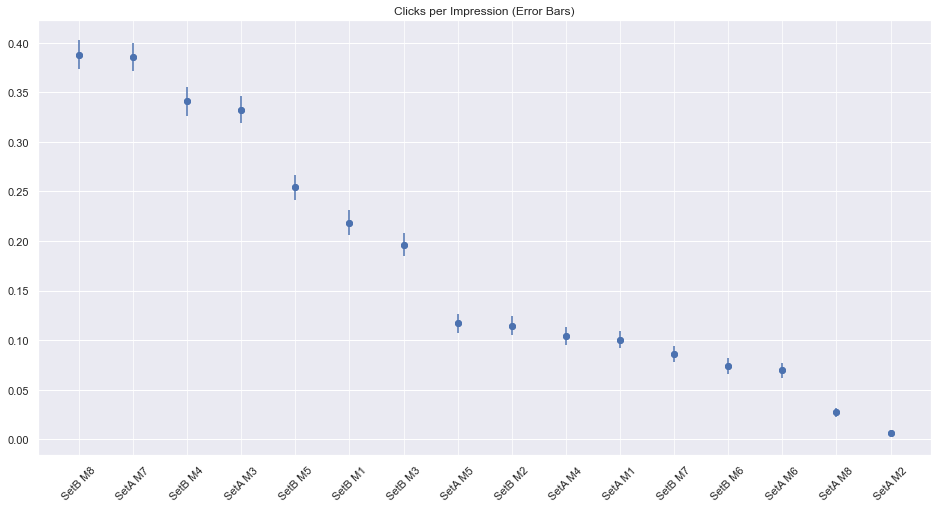

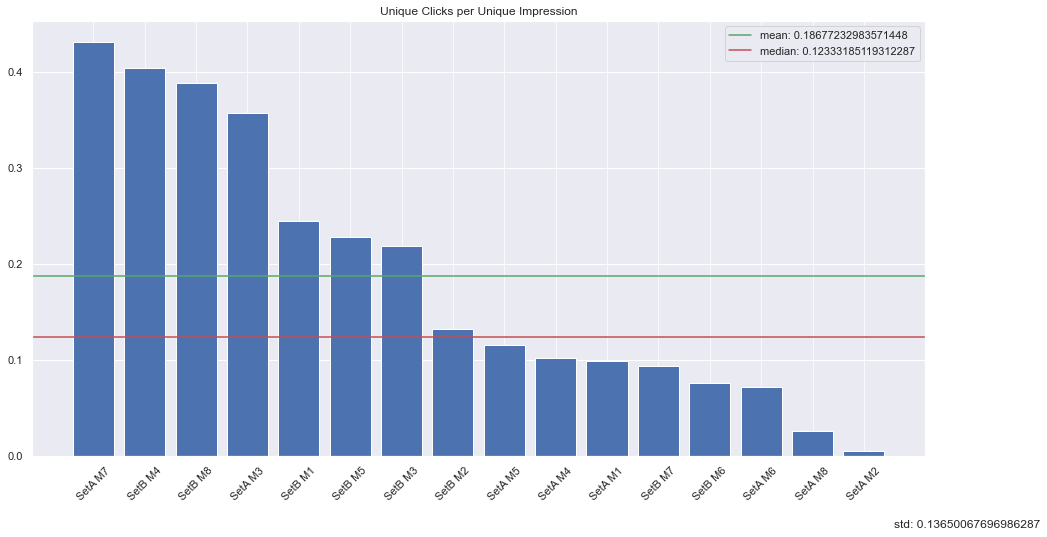

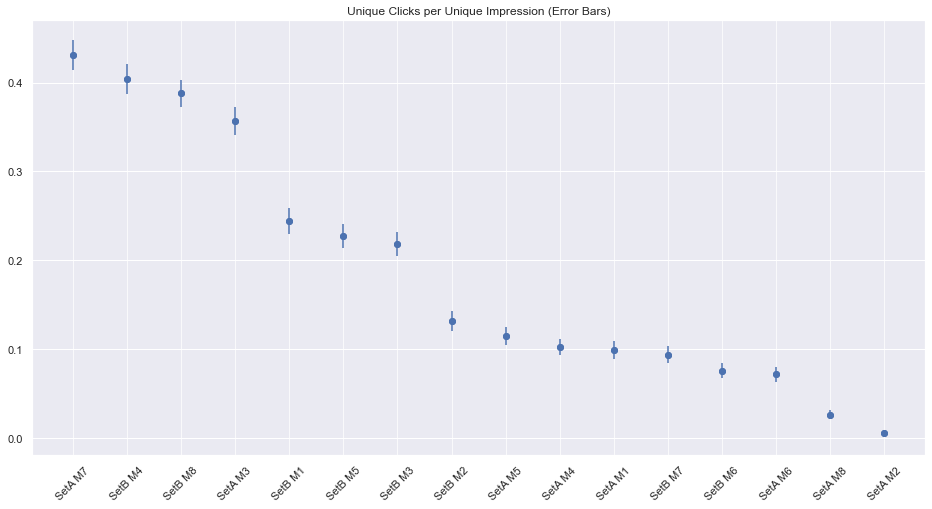

In [18]:
for i in [False, True]:
    display_df = get_metric_with_stder(
        df=df,
        aggregation='Ad Set Name',
        unique=i
    )
    rounded_display(df=display_df)
    display_metric_bar(
        df=display_df,
        aggregation='Ad Set Name',
        metric='Unique ' * i + 'Clicks per ' + 'Unique ' * i + 'Impression'
    )
    display_scatter_with_stder(
        df=display_df,
        aggregation='Ad Set Name',
        metric='Unique ' * i + 'Clicks per ' + 'Unique ' * i + 'Impression'
    )

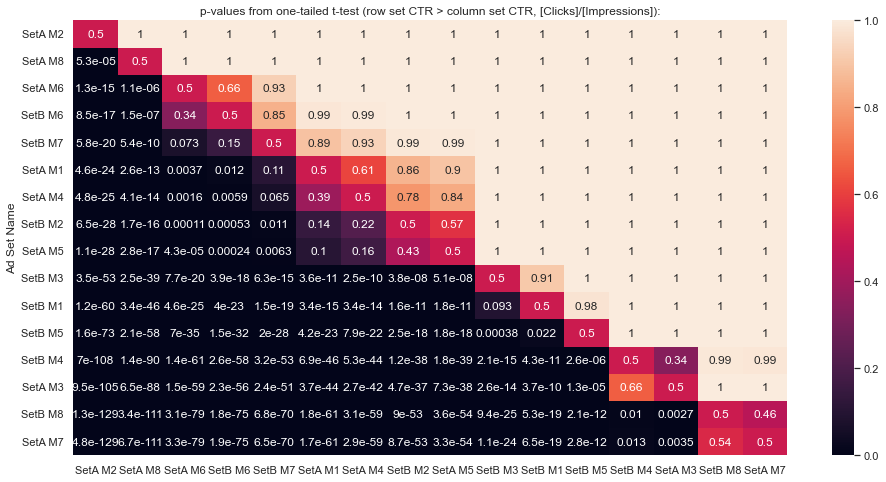

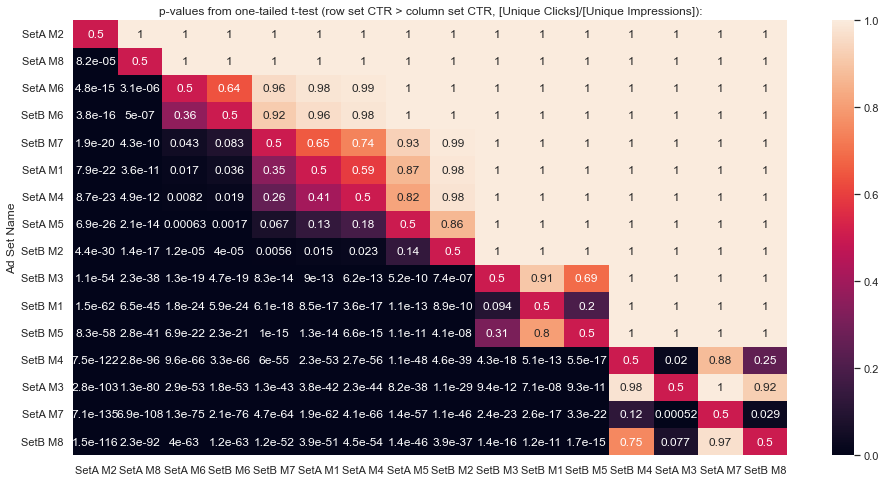

In [19]:
for i in [False, True]:
    get_pval_table(
        df=df,
        aggregation='Ad Set Name',
        click_metric='Unique ' * i + 'Clicks',
        impression_metric='Unique ' * i + 'Impressions'
    )

### Aggregated by creative

In [20]:
rounded_display(df=get_agg_data(df=df, aggregation='Creative'))

,Creative,Impressions,Unique Impressions,Clicks,Unique Clicks,Clicks per Impression,Unique Clicks per Unique Impression
0,SetA,9266,7590,1338,1126,0.14440,0.14835
1,SetB,9131,7395,1903,1648,0.20841,0.22285


,Creative,Clicks per Impression,Standard Error
1,SetB,0.20841,0.00425
0,SetA,0.14440,0.00365


,Creative,Unique Clicks per Unique Impression,Standard Error
1,SetB,0.22285,0.00484
0,SetA,0.14835,0.00408


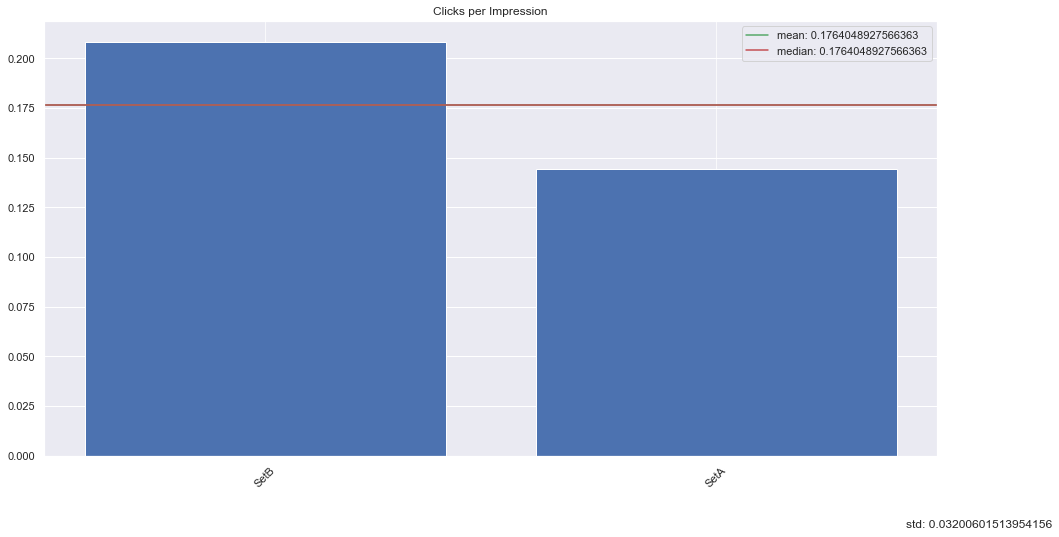

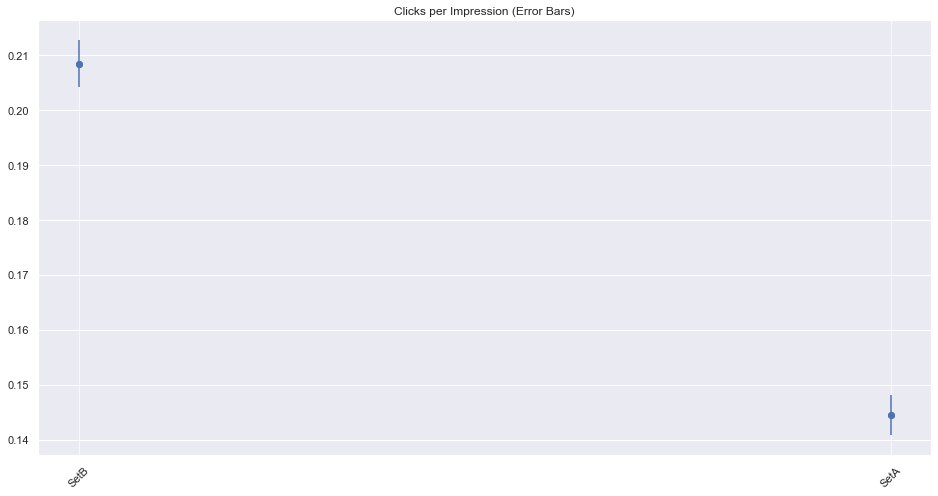

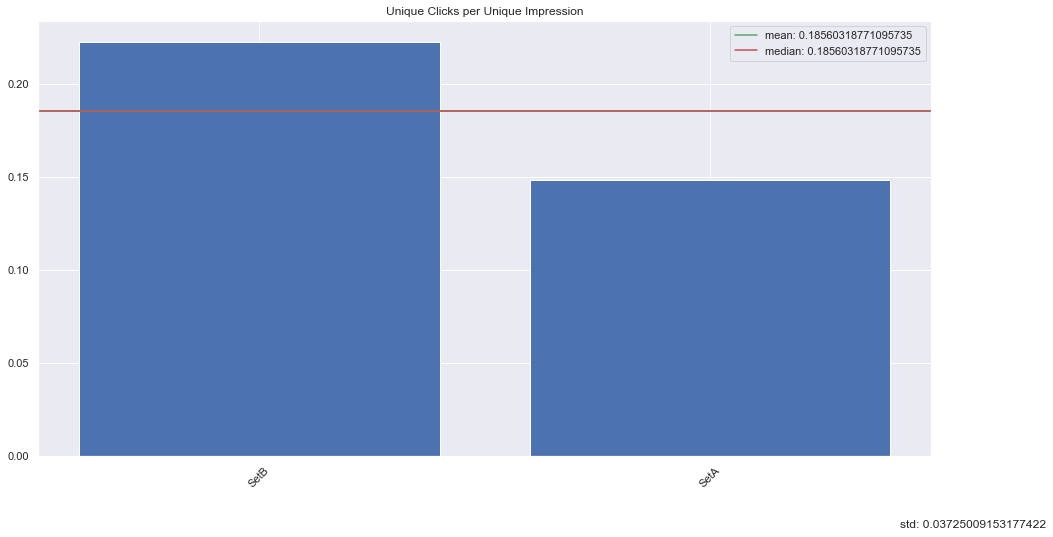

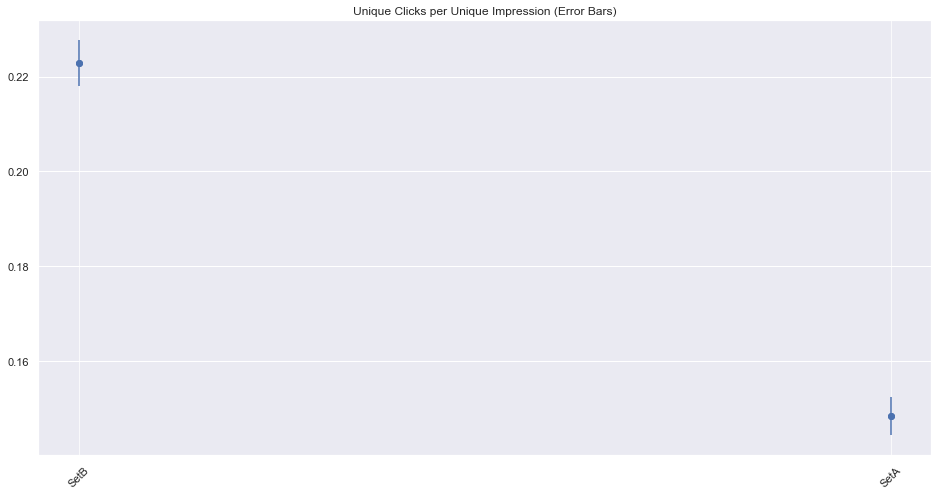

In [21]:
for i in [False, True]:
    display_df = get_metric_with_stder(
        df=df,
        aggregation='Creative',
        unique=i
    )
    rounded_display(df=display_df)
    display_metric_bar(
        df=display_df,
        aggregation='Creative',
        metric='Unique ' * i + 'Clicks per ' + 'Unique ' * i + 'Impression'
    )
    display_scatter_with_stder(
        df=display_df,
        aggregation='Creative',
        metric='Unique ' * i + 'Clicks per ' + 'Unique ' * i + 'Impression'
    )

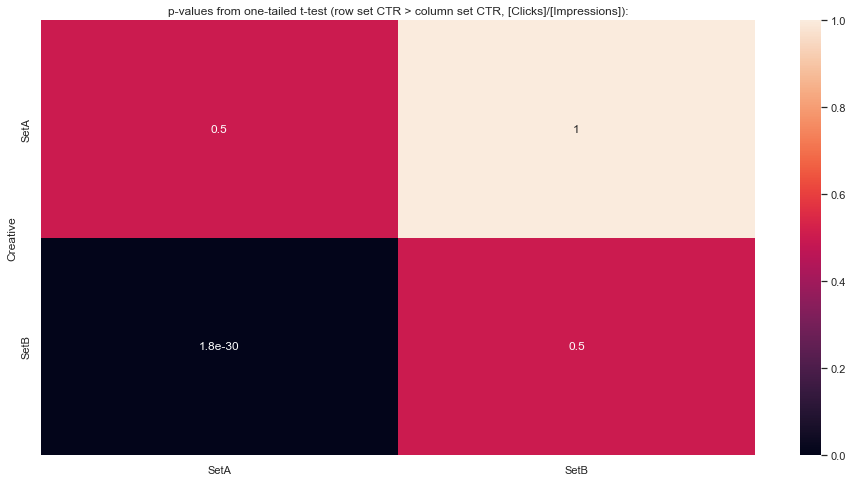

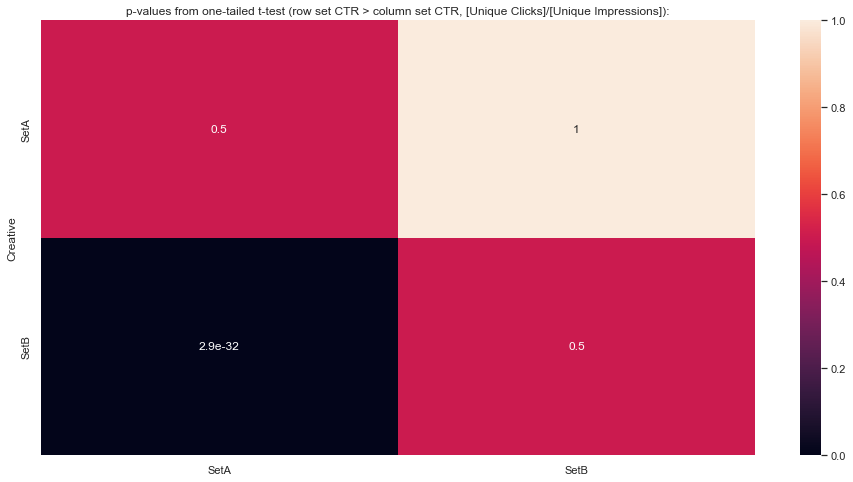

In [22]:
for i in [False, True]:
    get_pval_table(
        df=df,
        aggregation='Creative',
        click_metric='Unique ' * i + 'Clicks',
        impression_metric='Unique ' * i + 'Impressions'
    )

### Aggregated by message

In [23]:
rounded_display(df=get_agg_data(df=df, aggregation='Message'))

,Message,Impressions,Unique Impressions,Clicks,Unique Clicks,Clicks per Impression,Unique Clicks per Unique Impression
0,M1,2302,1795,366,305,0.15899,0.16992
1,M2,2229,1861,134,119,0.06012,0.06394
2,M3,2352,1904,623,548,0.26488,0.28782
3,M4,2264,1881,499,447,0.22041,0.23764
4,M5,2382,2000,442,345,0.18556,0.17250
5,M6,2283,1848,164,136,0.07184,0.07359
6,M7,2332,1783,550,466,0.23585,0.26136
7,M8,2253,1913,463,408,0.20550,0.21328


,Message,Clicks per Impression,Standard Error
2,M3,0.26488,0.00910
6,M7,0.23585,0.00879
3,M4,0.22041,0.00871
7,M8,0.20550,0.00851
4,M5,0.18556,0.00797
0,M1,0.15899,0.00762
5,M6,0.07184,0.00541
1,M2,0.06012,0.00504


,Message,Unique Clicks per Unique Impression,Standard Error
2,M3,0.28782,0.01038
6,M7,0.26136,0.01041
3,M4,0.23764,0.00982
7,M8,0.21328,0.00937
4,M5,0.17250,0.00845
0,M1,0.16992,0.00887
5,M6,0.07359,0.00608
1,M2,0.06394,0.00567


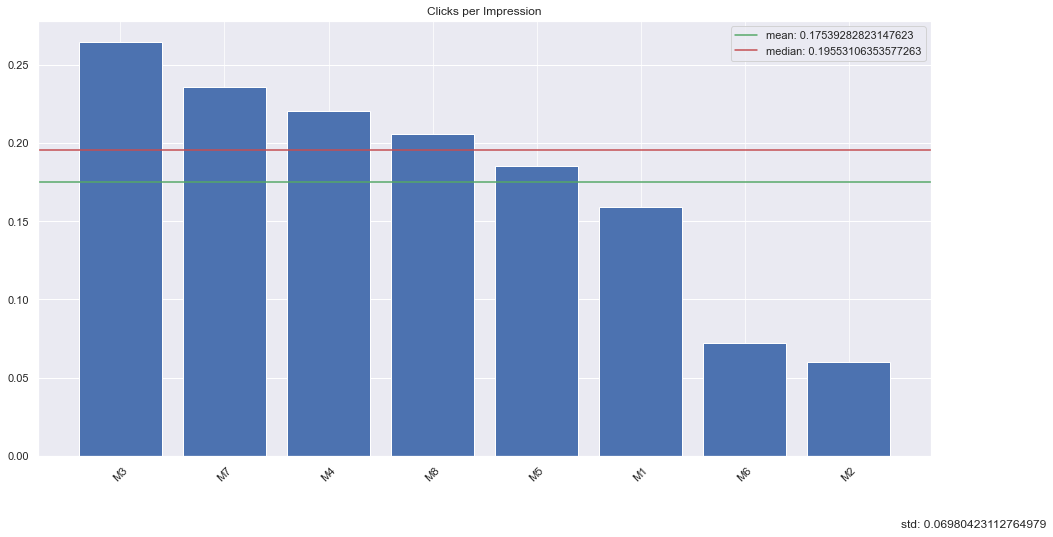

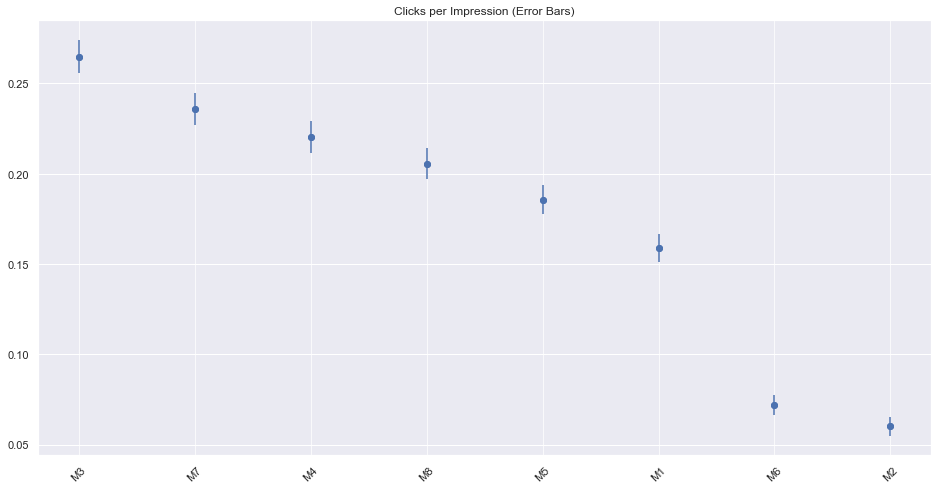

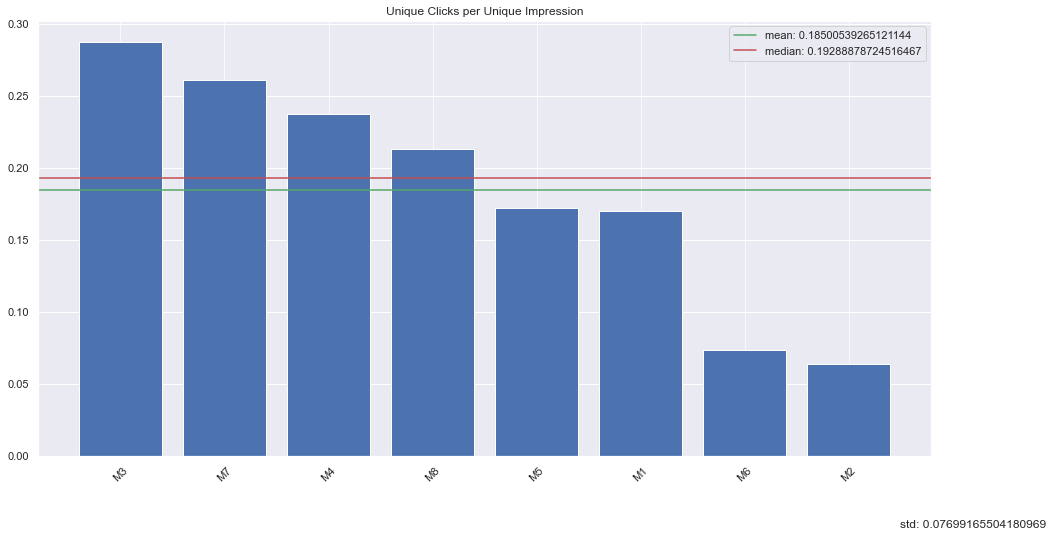

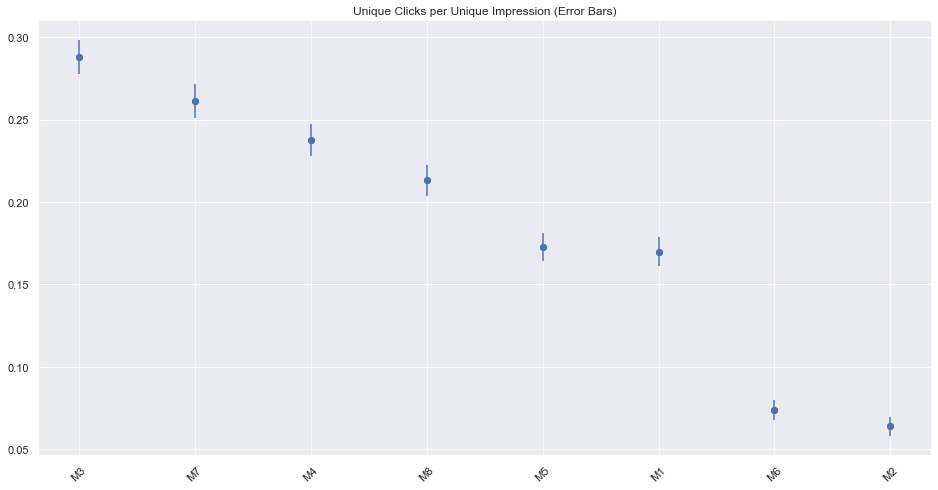

In [24]:
for i in [False, True]:
    display_df = get_metric_with_stder(
        df=df,
        aggregation='Message',
        unique=i
    )
    rounded_display(df=display_df)
    display_metric_bar(
        df=display_df,
        aggregation='Message',
        metric='Unique ' * i + 'Clicks per ' + 'Unique ' * i + 'Impression'
    )
    display_scatter_with_stder(
        df=display_df,
        aggregation='Message',
        metric='Unique ' * i + 'Clicks per ' + 'Unique ' * i + 'Impression'
    )

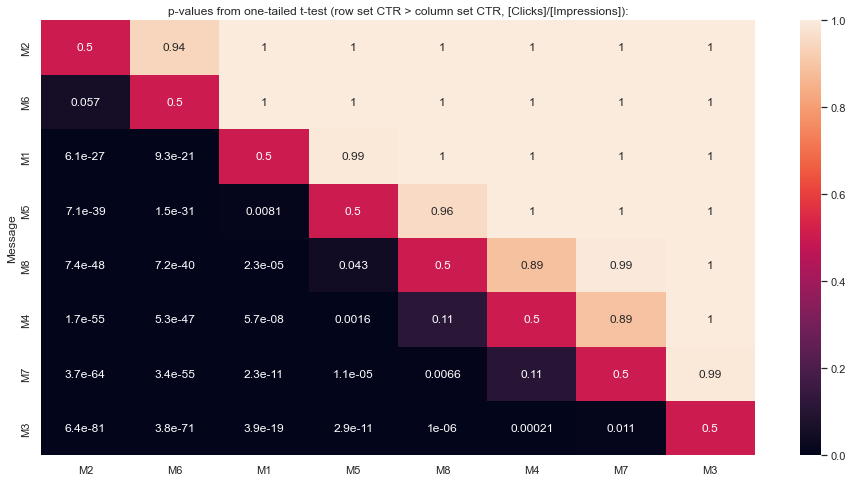

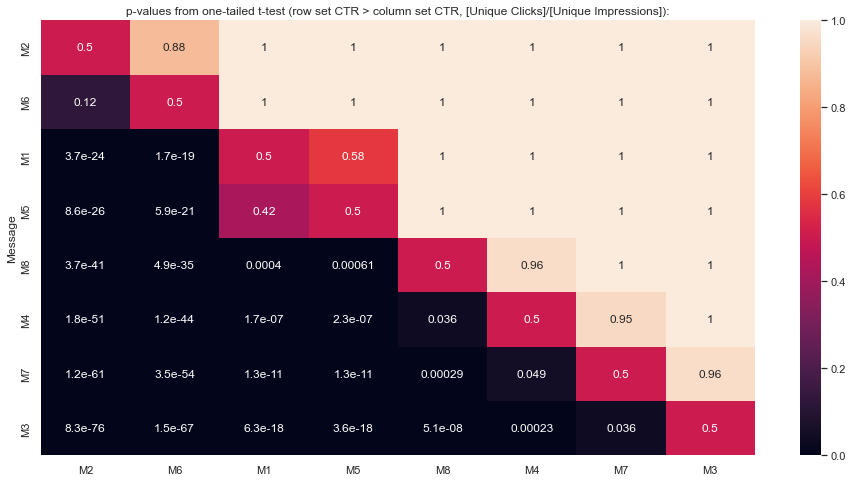

In [25]:
for i in [False, True]:
    get_pval_table(
        df=df,
        aggregation='Message',
        click_metric='Unique ' * i + 'Clicks',
        impression_metric='Unique ' * i + 'Impressions'
    )

## Pivot tables

In [26]:
for name in COLUMN_AGG:
    get_pivot_table(df=df.rename(columns=COLUMN_NAMES), feature=COLUMN_NAMES[name])

Impressions:


Message,M1,M2,M3,M4,M5,M6,M7,M8
Creative,,,,,,,,
SetA,1163,1120,1185,1152,1190,1150,1166,1140
SetB,1139,1109,1167,1112,1192,1133,1166,1113


Unique Impressions:


Message,M1,M2,M3,M4,M5,M6,M7,M8
Creative,,,,,,,,
SetA,918,996,959,1036,975,897,886,923
SetB,877,865,945,845,1025,951,897,990


Clicks:


Message,M1,M2,M3,M4,M5,M6,M7,M8
Creative,,,,,,,,
SetA,117,7,394,120,139,80,450,31
SetB,249,127,229,379,303,84,100,432


Unique Clicks:


Message,M1,M2,M3,M4,M5,M6,M7,M8
Creative,,,,,,,,
SetA,91,5,342,106,112,64,382,24
SetB,214,114,206,341,233,72,84,384


## Export notebook

In [28]:
!jupyter nbconvert --to html split_test_analysis.ipynb

[NbConvertApp] Converting notebook split_test_analysis.ipynb to html
[NbConvertApp] Writing 1423218 bytes to split_test_analysis.html
